# Pricing d'Options avec Monte Carlo

**With Black-Scholes formula, without any dividend yield** : 
$$
\begin{cases}
call_t(T,K) & = & S_t \times \mathcal{N}(d_1) - Ke^{-r(T-t)} \times \mathcal{N}(d_2) \\
put_t(T,K) & = & S_t \times \left(\mathcal{N}(d_1)-1\right) - Ke^{-r(T-t)} \times \left(\mathcal{N}(d_2)-1\right)\\
d_1 & = & \frac{ln \left(\frac{S_t}{K}\right) + \left( r-\frac{\sigma^2}{2} \right)(T-t)}{\sigma\sqrt{T-t}} \\
d_2 & = & d_1 - \sigma \sqrt{T-t}
\end{cases}
$$

**Aim** : Pricing option at begining $t=0$, thus, 
$$
\begin{cases}
call_0(T,K) & = & S_0 \times \mathcal{N}(d_1) - Ke^{-rT} \times \mathcal{N}(d_2) \\
put_0(T,K) & = & S_0 \times \left(\mathcal{N}(d_1)-1\right) - Ke^{-rT} \times \left(\mathcal{N}(d_2)-1\right)\\
d_1 & = & \frac{ln \left(\frac{S_0}{K}\right) + \left( r-\frac{\sigma^2}{2} \right)T}{\sigma\sqrt{T}} \\
d_2 & = & d_1 - \sigma \sqrt{T}
\end{cases}
$$

**With** :
$$
\mathcal{N}(x) = {\frac{1}{\sqrt{2\pi}}}\int_{-\infty}^{x} e^{\frac{-x^2}{2}}dx
$$


In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class BlackScholes:
    def __init__(self, S:float=100, K:float=100, r:float=0.05, sigma:float=0.1,T:float=1):
        self.S = S
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        
    def param(self):
        d1 = (np.log(self.S/self.K)+(self.r-self.sigma**2 *0.5)*self.T)/(self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        
        return d1,d2
    
    def call(self, buy:bool = True):
        d1 = self.param()[0]
        d2 = self.param()[1]
        price = self.S*norm.cdf(d1) - self.K*np.exp(-self.r*self.T) *norm.cdf(d2)
        if buy == True:
            return price
        if buy == False: 
            return -price


In [3]:
# Paramètres

S0 = 100
K = 90
T = 3/12
r = 0.03
sigma = 0.25

In [4]:
test = BlackScholes(S0,K,r,sigma,T)
call_price = test.call(buy=True)
print(f"With Black-Scholes formula, the call's price is {round(call_price,3)}€")


With Black-Scholes formula, the call's price is 11.825€


# Monté-Carlo

Nous allons simuler des trajectoires aléatoirement. A l'aide de la formule suivante,
$$
S_t = S_0 \times e^{\left( \mu - \frac{1}{2} \sigma^2 \right)dt +  \sigma \sqrt{dt}w}
$$
Par la suite, nous allons simuler $n$ trajectoires, sur lesquels, seules les valeurs à maturité, donc à la date $t=T$, nous intéresse. Par la suite, nous devons faire en sorte que les valeurs à maturité ressemble aux payoffs d'une option que l'on choisit, par exemple l'option Call, de ce fait, il faut soustraire par le strike $K$ et prendre le maximum entre cette valeur et 0, cela va donner :
$$
max(S_T-K,0)
$$
Enfin, le prix de l'option se trouvera en faisant la moyenne de tous les payoffs, et en actualisant cette dernière actualiser:
$$
\begin{matrix}
call_{MC} & = & \mathbb{E}[max(S_T - K,0)]e^{-rT}
\end{matrix}
$$

In [5]:
class MBG:
    def __init__(self, S0 : float = 100, sig : float = 0.2, mu : float = 0.05, T : float = 1):
        self.S0 = S0
        self.sig = sig
        self.mu = mu
        self.T = T
        self._test = []
        
    def wienner(self, N : int = 1000): 
        dt = self.T/N
        W = np.random.standard_normal(size = N+1)
        W = np.cumsum(W) * np.sqrt(dt)        
        return W
    
    def gen_MBG(self, N : int = 1000):
        dt = self.T/N
        W = self.wienner(N)
        dt = self.T/N
        S = self.S0 * np.exp((self.mu - 0.5 * self.sig**2)*dt + (self.sig * W))
        S = np.insert(S, 0, self.S0)
        return S
    
    def multiple_MBG(self, n: int = 1000):
        """
        Paramètre :
            - n, type : int - Nombre de simulations
        
        Description:
            Cette méthode permet à appeler n fois la précédente méthode gen_MBG(N)
        """
        listsimulation = []
        for i in range(n):
            simul = self.gen_MBG(100)
            listsimulation.append(simul)
        return listsimulation
    
    def last_price(self,n:int = 1000,K:float = 100):
        lastsimulation = []
        for i in range(n):
            simul = self.gen_MBG(100)
            lastsimulation.append(simul[-1])
        
        df = pd.DataFrame({"Dernier prix":lastsimulation})
        df["Payoff"] = np.maximum(df["Dernier prix"] - K,0)
        
        self.test = df
        return df

In [6]:
T = 3/12

Geometric = MBG(S0 = 100, sig = 0.25, mu = 0.03, T = T)

n = 10000
last = Geometric.last_price(n,K=90)
payoff = pd.DataFrame(last["Payoff"])
mean = payoff.mean()[0]
print(f"With Monte-Carlo method, the call's price is {round(mean*np.exp(-r*T),3)}€")

With Monte-Carlo method, the call's price is 11.871€


In [7]:
Geometric.wienner().shape

(1001,)

In [8]:
Geometric.test

,Dernier prix,Payoff
0,107.167593,17.167593
1,115.427499,25.427499
2,90.489769,0.489769
3,99.953378,9.953378
4,106.180943,16.180943
...,...,...
9995,131.188021,41.188021
9996,107.822187,17.822187
9997,119.525802,29.525802
9998,118.195150,28.195150


In [9]:
Geometric.gen_MBG()

array([100.        ,  99.2740028 ,  99.11653741, ..., 100.15251969,
       100.15525491,  99.89327133])

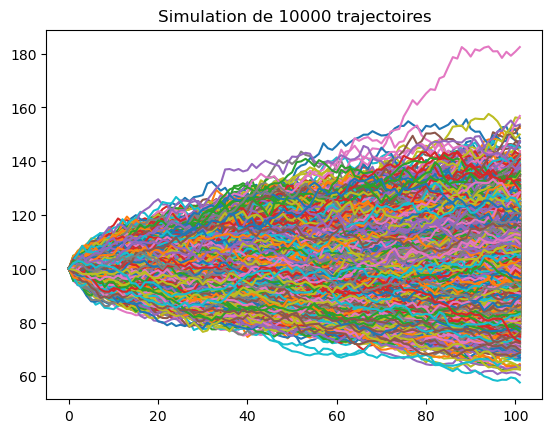

In [10]:
# Affichage
simulation = Geometric.multiple_MBG(n)
for simul in simulation:
    plt.plot(simul)

plt.title(f"Simulation de {n} trajectoires")
plt.show()